Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [159]:
%matplotlib inline

In [160]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [161]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [162]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [163]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [164]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

In [165]:

def lane(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))

'''

def nominal(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))


def lane(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((ts[3] - posx)/(2 * rate)))
    
def nominal(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((posx - ts[3])/(2 * rate)))
'''

def barrier_u(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
                                                                      
def barrier_l(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    
def nominal(posx):
    return (barrier_u(posx)[1] + barrier_l(posx)[1]) * 0.5, (barrier_u(posx)[2] + barrier_l(posx)[2]) * 0.5

    
  

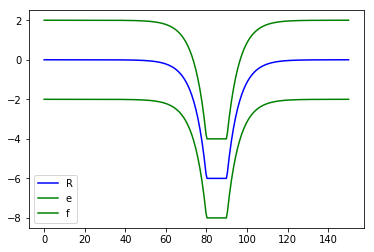

In [181]:
posx_path = np.linspace(0, 150, 300)
x_nominal = [[posx_path[i], nominal(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]
x_barrier_u = [[posx_path[i], barrier_u(posx_path[i])[1], 10, barrier_u(posx_path[i])[1]] for i in range(300)]
x_barrier_l = [[posx_path[i], barrier_l(posx_path[i])[1], 10, barrier_l(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_nominal)[:, 0]
posy_ = np.asarray(x_nominal)[:, 1]
posy_u = np.asarray(x_barrier_u)[:, 1]
posy_l = np.asarray(x_barrier_l)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_u, 'g')
_ = plt.plot(posx_, posy_l, 'g')
_ = plt.legend("Reference Path")


In [185]:
n = 2
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 100)#, checkpoint = 'checkpoints/mlp_H2_995.pt')

agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
agent.train(num_epoch = 1000)


27416


/usr/lib/python3/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/lib/python3/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[Epoch 1] avg_loss: 0.684
[Epoch 6] avg_loss: 0.684
[Epoch 11] avg_loss: 0.683
[Epoch 16] avg_loss: 0.685
[Epoch 21] avg_loss: 0.686
[Epoch 26] avg_loss: 0.683
[Epoch 31] avg_loss: 0.684
[Epoch 36] avg_loss: 0.684
[Epoch 41] avg_loss: 0.685
[Epoch 46] avg_loss: 0.685
[Epoch 51] avg_loss: 0.684
[Epoch 56] avg_loss: 0.686
[Epoch 61] avg_loss: 0.687
[Epoch 66] avg_loss: 0.684
[Epoch 71] avg_loss: 0.684
[Epoch 76] avg_loss: 0.684
[Epoch 81] avg_loss: 0.685
[Epoch 86] avg_loss: 0.684
[Epoch 91] avg_loss: 0.683
[Epoch 96] avg_loss: 0.683
[Epoch 101] avg_loss: 0.684
[Epoch 106] avg_loss: 0.684
[Epoch 111] avg_loss: 0.683
[Epoch 116] avg_loss: 0.684
[Epoch 121] avg_loss: 0.685
[Epoch 126] avg_loss: 0.683
[Epoch 131] avg_loss: 0.685
[Epoch 136] avg_loss: 0.683
[Epoch 141] avg_loss: 0.684
[Epoch 146] avg_loss: 0.684
[Epoch 151] avg_loss: 0.684
[Epoch 156] avg_loss: 0.683
[Epoch 161] avg_loss: 0.684
[Epoch 166] avg_loss: 0.683
[Epoch 171] avg_loss: 0.685
[Epoch 176] avg_loss: 0.684
[Epoch 181] av

In [186]:

agent_traj = []
batch_size = 5
for i_batch in range(batch_size):
    agent_traj.append([])
    x0 = [x_nominal[0][0] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 3.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 3.0 * (2 * random.random() - 1.0)]  # Initial state.

    N = 300
    H = 2
    
    for _ in range(0, N):
        i = abs(int(x0[0]/0.5))
        x_nn = []
        if i >= N - H - 1:
            break
        x_nominal_ = x_nominal[i: i + H]
        for j in [x0] + x_nominal_[:]:
            for k in j:
                x_nn.append(k)
        u = agent.run([x_nn])
        agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
        x1 = dynamics.f(x0, u[0], i)[0]        
        x0 = x1[:]

print("Done")

/usr/lib/python3/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/lib/python3/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Done


The red curve in the plot shows the trajectory of the regression model controller.

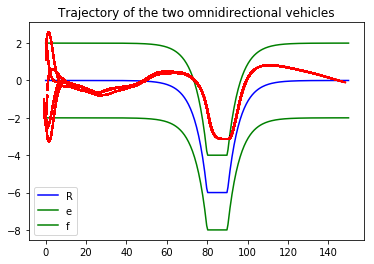

In [187]:
def draw_agent_traj(x_path, agent_traj):
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.legend(["Vehicle", "Reference Path"])
    
    posx_ = np.asarray(x_path)[:, 0]
    posy_ = np.asarray(x_path)[:, 1]
    posy_u = np.asarray(x_barrier_u)[:, 1]
    posy_l = np.asarray(x_barrier_l)[:, 1]
    _ = plt.plot(posx_, posy_, "b")
    _ = plt.plot(posx_, posy_u, 'g')
    _ = plt.plot(posx_, posy_l, 'g')
    _ = plt.legend("Reference Path")

    posx = []
    posy = []
    v = []
    theta = []
    for i in agent_traj:
        posx.append([])
        posy.append([])
        v.append([])
        theta.append([])
        for j in i:
            posx[-1].append(j[0][0])
            posy[-1].append(j[0][1])
            v[-1].append(j[0][2])
            theta[-1].append(j[0][3])
            plt.plot(posx[-1], posy[-1], "r")

    plt.show()

draw_agent_traj(x_nominal, agent_traj)

In [175]:
N = len(x_nominal)
H = 2  # Number of time steps in trajectory.
n = 30
n_init = 0
#n_end = 250
n_end = N - H - 1
x0 = x_nominal[n_init]  # Initial state.

x0s = [[x_nominal[0][0] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][2] + 1.0 * (2 * random.random() - 1.0), \
              x_nominal[0][3] + 3.0 * (2 * random.random() - 1.0)] for i in range(1)]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))



# Instantenous state cost.
Q = 0.0 * np.eye(dynamics.state_size)
Q[3, 3] = 0.0

R = np.eye(dynamics.action_size)
R[0, 0] = 0.0
R[1, 1] = 0.0


q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[-0.0], [0.0]])
q1 = [150.0, 150.0]
q2 = [150.0, 150.0]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

def MPSC(agent, x0s):
    train_traj = []
    nn_traj = []
    mpc_traj= []
    traj = []
    for num in range(len(x0s)):
        train_traj.append([])
        nn_traj.append([])
        mpc_traj.append([])
        traj.append([])
        x0 = x0s[num]
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            i = abs(int(x0[0]/0.5))
            if i > n_end:
                break
            x_nominal_ = x_nominal[i: i + H]
            x_nn = []
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            #print("NN outputs control")
            agent_traj[-1] = agent_traj[-1] + [[x0, u[0, :]]]
            x1 = dynamics.f(x0, u[0], i)[0]
            #print("Get next state")

            if i <= n_end - n - 1:
                n_ilqr =  n 
            elif n_end > i:
                n_ilqr = n_end - i
            else:
                break

            x0_ = x1[:]
            us_ = []
            xs_ = []
            for _ in range(n_ilqr):
                i_ = abs(int(x0_[0]/0.5))
                x_nn_ = []
                for j in [x0_] + x_nominal[i_ : i_ + H]:
                    for k in j:
                        x_nn_.append(k)
                while len(x_nn_) < 4 *(H + 1):
                    for k in x_nominal[-1]:
                        x_nn_.append(k)
                u_ = agent.run([x_nn_])
                xs_.append(x0_[:])
                us_.append(u_[0])
                x1_ = dynamics.f(x0_, u_[0], i_)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[0].T) - b[0,0]\
                           <= 0)).all() == True and \
                (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[1].T) - b[1,0]\
                          <= 0)).all() == True:
                traj[-1].append([x0, u[0, :]])
                nn_traj[-1].append(traj[-1][-1])
                train_traj[-1].append([x_nn, u[0, :]])
                print("Utilize NN output {}".format(u))
            else: 
                x_nominal_ilqr = x_nominal[i + 1: i + 1 + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))


                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
                xs, us = ilqr_.fit(x1, us_init, on_iteration=on_iteration)
                #print("MPC verifying")


                if (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    traj[-1].append([x0, u[0, :]])
                    nn_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, u[0, :]])
                    print("Utilize NN output {}".format(u))
                else:
                    max_itr = 5
                    while (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).any() == False or \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).any() == False :
                        if max_itr == 0:
                            break
                        max_itr -= 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
                    traj[-1].append([x0, us[0]])
                    mpc_traj[-1].append(traj[-1][-1])
                    train_traj[-1].append([x_nn, us[0]])
                    x1 = dynamics.f(x0, us[0], i)[0]
                    print("Utilize MPC output {}".format(us[0]))
            x0 = x1[:]
            
        return  traj, nn_traj, mpc_traj, train_traj
    
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)

>>>>>Step 0 at [0.071707415378427619, -0.15047527561433305, 9.836748180556448, -2.6386438812866029]
iteration 0 accepted [  8.74306331e+55] [ 10.95247354  -0.2400638   10.27114705  -0.04716368] [ 0.31258267  0.05244622]
Utilize MPC output [-28.97638702   2.69310331]
>>>>>Step 1 at [-0.35812812 -0.38694392  9.78674818 -2.15129049]
iteration 0 accepted [  7.45083105e+23] [ 12.38241005  -0.15790474  10.22271625  -0.04350132] [ 0.02615157 -0.0523413 ]
Utilize MPC output [  1.36153927e+22   8.93670103e+20]
>>>>>Step 2 at [-0.62718451 -0.79716906  9.83674818 -1.66195308]


/usr/lib/python3/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/lib/python3/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:161: UserWarning: Singular matrix
  warnings.warn(str(e))
/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


iteration 0 accepted [  1.07037196e+38] [ 12.91140403  -0.16360378  10.22387527  -0.04081889] [ 0.0983356 -0.3545422]
Utilize MPC output [  6.09714386e+12   9.78796626e+10]
>>>>>Step 3 at [-0.67207054 -1.28820922  9.88674818 -1.17011567]
iteration 0 accepted [  1.08751569e+31] [ 13.4728023   -0.58583257  10.23938855  -0.03654036] [ 0.23136708 -0.12980154]
Utilize MPC output [-1.16443455  0.90253383]
>>>>>Step 4 at [-0.47965762 -1.74244632  9.84562419 -0.81541405]
iteration 0 accepted [  9.39377120e+27] [ 11.30124005  -0.70964469  10.22098042  -0.023095  ] [ 1.46673441 -0.51041341]
Utilize MPC output [-541.5736084     2.57876015]
>>>>>Step 5 at [-0.14302282 -2.09992171  9.79562419 -0.32876751]
iteration 0 accepted [  2.51502252e+25] [ 14.32198393  -0.63277043  10.15453919  -0.03940783] [ 0.20820028 -0.17136133]
Utilize MPC output [-50954.9453125     58.7868576]
>>>>>Step 6 at [ 0.31934315 -2.2576571   9.74562419  0.1610137 ]
iteration 0 converged [  7.87239577e+18] [ 14.80348198  -0.427

Utilize NN output [[ 0.15391612 -0.0014334 ]]
>>>>>Step 72 at [  3.33447566e+01  -1.99955189e-02   1.04392979e+01   4.26293729e-02]
Utilize NN output [[ 0.15308657 -0.00109151]]
>>>>>Step 73 at [  3.38664370e+01   2.25687027e-03   1.04468929e+01   4.20596434e-02]
Utilize NN output [[ 0.15221012 -0.00081143]]
>>>>>Step 74 at [  3.43885083e+01   2.42279618e-02   1.04544452e+01   4.16357986e-02]
Utilize NN output [[ 0.15128952 -0.00058883]]
>>>>>Step 75 at [ 34.9109651    0.04599345  10.46195251   0.041328  ]
Utilize NN output [[ 0.15032528 -0.00041825]]
>>>>>Step 76 at [ 35.43380241   0.06761358  10.46941266   0.04110922]
Utilize NN output [[ 0.14931808 -0.0002957 ]]
>>>>>Step 77 at [ 35.9570159    0.0891346   10.47682357   0.04095443]
Utilize NN output [[ 0.14826643 -0.0002088 ]]
>>>>>Step 78 at [ 36.48060166   0.11058975  10.48418304   0.04084505]
Utilize NN output [[ 0.14717625 -0.00015256]]
>>>>>Step 79 at [ 37.0045561    0.13200261  10.49148918   0.04076508]
Utilize NN output [[ 0.2

Utilize MPC output [-2666.57055664  -127.11344147]
>>>>>Step 127 at [ 62.49364499   0.21422805  10.77084865  -0.86939629]
iteration 0 failed 9.40057243668e+116 [ 78.15952496  -0.7151641   10.77879675  -0.33525127] [ 0.00122841 -0.06221667]
Utilize MPC output [-18515392.         -155692.515625]
>>>>>Step 128 at [ 62.84035328  -0.19623087  10.72084865  -1.40793872]
iteration 0 accepted [  1.38360110e+78] [ 70.7845891   -2.22145539  10.07266386   0.56984586] [ -4.65508643e+03  -2.56318808e+00]
Utilize MPC output [ 1144.73413086    -7.15813923]
>>>>>Step 129 at [ 62.92746915  -0.72641384  10.77084865  -1.9439805 ]
iteration 0 failed 5.65115742744e+78 [ 76.57105808  -0.26153999  10.78569157  -0.24039734] [ 0.00158449 -0.05333202]
Utilize MPC output [ 0.05505087  0.99643439]
>>>>>Step 130 at [ 62.73110106  -1.22795304  10.77359841  -1.53463837]
iteration 0 accepted [  6.58279707e+79] [ 67.81291436   2.32670273  11.72635166   7.08207351] [  1.93456914e+04  -1.47630234e+01]
Utilize MPC output 

Utilize MPC output [ 0.00868279  0.31443411]
>>>>>Step 158 at [ 71.50007545   0.33848178  10.63260455  -0.54627328]
iteration 0 failed 1.49991429472e+166 [  8.69103988e+01  -3.10010841e+00   1.06359894e+01  -3.88303049e-02] [ 0.00081291  0.01701831]
Utilize MPC output [ 0.00406294  0.2592417 ]
>>>>>Step 159 at [  7.19543400e+01   6.22937932e-02   1.06328077e+01  -4.11459223e-01]
iteration 0 failed 7.61766293773e+165 [  8.74372354e+01  -3.12034153e+00   1.06358400e+01  -3.26298195e-02] [ 0.0007783   0.01185365]
Utilize MPC output [ 0.00374219  0.20103396]
>>>>>Step 160 at [ 72.44161302  -0.15033615  10.6329948   -0.30599836]
iteration 0 failed 2.87560207043e+165 [  8.79692472e+01  -3.13740396e+00   1.06358779e+01  -2.85829669e-02] [ 0.00073841  0.00781613]
Utilize MPC output [ 0.00332432  0.15240514]
>>>>>Step 161 at [ 72.94856983  -0.31049439  10.63316102  -0.22559377]
iteration 0 failed 1.38501654427e+165 [  8.85024837e+01  -3.15243521e+00   1.06357709e+01  -2.61425627e-02] [ 0.000700

Utilize NN output [[ 0.00176083  0.20684601]]
>>>>>Step 193 at [ 88.20727487  -4.44192681  10.39240714   0.19307101]
Utilize NN output [[ 0.00179524  0.11349511]]
>>>>>Step 194 at [ 88.71724268  -4.34222487  10.3924969    0.25179346]
Utilize NN output [[ 0.00189332  0.04331294]]
>>>>>Step 195 at [ 89.22048457  -4.21276429  10.39259157   0.27428588]
Utilize NN output [[ 0.00204094 -0.00537429]]
>>>>>Step 196 at [ 89.72069226  -4.07201695  10.39269362   0.27149327]
Utilize NN output [[ 0.00290872 -0.07488175]]
>>>>>Step 197 at [ 90.22129702  -3.93266538  10.39283905   0.23265468]
Utilize NN output [[ 0.00273129  0.1082461 ]]
>>>>>Step 198 at [ 90.72694198  -3.81285518  10.39297562   0.28868522]
Utilize NN output [[ 0.00279946  0.10112922]]
>>>>>Step 199 at [ 91.22509053  -3.66491428  10.39311559   0.34105847]
Utilize NN output [[ 0.0029586  0.0856256]]
>>>>>Step 200 at [ 91.71481822  -3.49109609  10.39326352   0.38544588]
Utilize NN output [[ 0.00322325  0.06594785]]
>>>>>Step 201 at [ 9

Utilize NN output [[ 0.01667816 -0.00036439]]
>>>>>Step 267 at [  1.25959264e+02   7.05338883e-02   1.04479134e+01  -2.93214942e-02]
Utilize NN output [[ 0.01610103 -0.00033703]]
>>>>>Step 268 at [  1.26481456e+02   5.52180714e-02   1.04487184e+01  -2.94975596e-02]
Utilize NN output [[ 0.01554451 -0.0003058 ]]
>>>>>Step 269 at [  1.27003684e+02   3.98091484e-02   1.04494956e+01  -2.96573213e-02]
Utilize NN output [[ 0.03907377 -0.00104251]]
>>>>>Step 270 at [  1.27525977e+02   2.43147698e-02   1.04514483e+01  -3.02020088e-02]
Utilize NN output [[ 0.03757028 -0.00074217]]
>>>>>Step 271 at [  1.28048358e+02   8.53301500e-03   1.04533259e+01  -3.05898448e-02]
Utilize NN output [[ 0.03612514 -0.00051251]]
>>>>>Step 272 at [  1.28570825e+02  -7.45415296e-03   1.04551314e+01  -3.08577167e-02]
Utilize NN output [[ 0.03473417 -0.0003359 ]]
>>>>>Step 273 at [  1.29093376e+02  -2.35840062e-02   1.04568674e+01  -3.10333116e-02]
Utilize NN output [[ 0.03339784 -0.00021276]]
>>>>>Step 274 at [  1.2

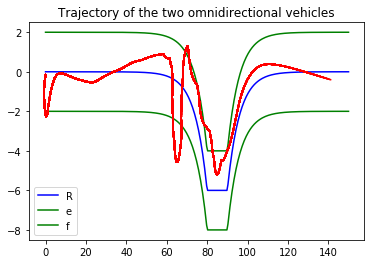

In [176]:
draw_agent_traj(x_nominal, traj)

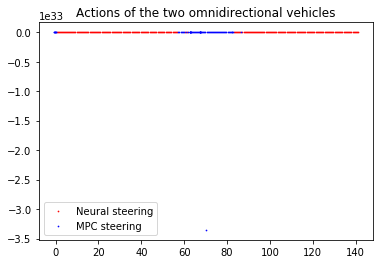

In [177]:
def draw_str(nn_traj, mpc_traj):
    str_nn = []
    posx_nn = []
    str_mpc = []
    posx_mpc = []
    for i in nn_traj[-1]:
        posx_nn.append(i[0][0])
        str_nn.append(i[1][1])
    for j in mpc_traj[-1]:
        posx_mpc.append(j[0][0])
        str_mpc.append(j[1][1])  

    _ = plt.title("Actions of the two omnidirectional vehicles")
    _ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
    _ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
    _ = plt.legend(["Neural steering", "MPC steering"])

draw_str(nn_traj, mpc_traj)

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=\pi(x_k; \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& \pi(x_k; \theta)\\
u_k + \delta u_k &=& \pi(x_k + \delta x_k; \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x \pi(x_k; \theta) \delta x_k + \nabla_\theta \pi(x_k; \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

Previously, we used L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$, to estimate the loss $L(\delta\theta)$. The optimization problem is as follows.

\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

It is a typical Quadratic Programming problem especially if the constrains are all convex. But it would be extremely computationally expensive for traditional QP solver because the size of $\nabla_\theta \pi(x; \theta)$ can be immensively large. 

Considering the difficulty, we can alternate the problem in the following way.

Firstly, given the current model parameter $\theta_i$, the linearization of the perturbation on the learning model can be rearranged in the following way.

$$\delta \theta_i^T \nabla_\theta \pi(x_k; \theta_i) \approx \delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)$$

Let the optimal control at state $x_k$ be $u^*_k$, which can be presumably obtained with the initial model parametere $\theta_0$, i.e. $u^*_k= \pi(x_k; \theta_0)$. The loss of the model based on this specific data point can be evaluated by using square error  
$$J_{(x_k, u^*_k)}(\theta_i) = ||\pi(x_k; \theta_i) - u^*_k||^2_2$$ 
or log likelihood with fixed covariance $\Sigma$
$$J_{(x_k, u^*_k)}(\theta_i) = -log[\frac{1}{(2\pi)^{\frac{n}{2}}\Sigma} exp\{-\frac{1}{2}[\pi(x_k; \theta_i) - u^*_k]^T \Sigma^{-1}[\pi(x_k,\theta_i)-u^*_k]\}$$

Either way, up to a scale of constant, $\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)= \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]$.

Evaluating the loss of the model based on a set $D=\{\tau = (x_0, u^*_0, \ldots, x_k, u^*_k, \ldots)\}$ of trajectories sampled from the roll-out of the unchanged model, then the increase on the model's loss due to the perturbation is $J_{D}(\theta_i+\delta\theta_i) - J_{D}(\theta_i)\approx \delta\theta_i^T \nabla_\theta J_{D}(\theta_i) + \frac{1}{2}\delta\theta_i^T \nabla^2_\theta J_{D}(\theta_i)\delta\theta_i$ and it is to be minimized.

Using Fisher Information Matrix to replace the second order derivative, the increase of loss turns out to be
\begin{eqnarray}
&&\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T]\delta\theta_i\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} [\delta\theta_i^T\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}[\delta\theta_i^T \nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T\delta\theta_i]\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} \{\delta\theta_i^T\nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]\} + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{\delta\theta_i^T \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T\nabla_\theta \pi(x_k; \theta_i)^T\delta\theta_i\}\\
&\approx& \mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k]\}+ \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)]^T\}\\
&\approx& \frac{1}{4|D|} \sum_{(x_k, u^*_k)\in D} \\
&&\begin{bmatrix} 1\\\delta x_k \\ \delta u_k\end{bmatrix}^T 
\begin{bmatrix} 
0 &-2[\pi(x_k; \theta_i) - u^*_k]^T\nabla_x \pi(x_k; \theta_i)^T &  2[\pi(x_k; \theta_i) - u^*_k]^T\\ 
-2\nabla_x \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \\
2[\pi(x_k; \theta_i) - u^*_k] & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T 
\end{bmatrix} 
\begin{bmatrix}1\\\delta x_k \\ \delta u_k\end{bmatrix} 
\end{eqnarray}

As a result, we get a quadratic objective function of which the variables are only $\delta x$ and $\delta u$. As $\pi(,)$ is considered, variable $\delta\theta$ is implicit in this objective function. After solving the $\delta x$ and $\delta u$, $\delta\theta$ can be directly derived and used to modify $\theta_i$. One thing to be stressed is that $\pi(x_k;\theta_i + \delta\theta_i)\neq u_k + \delta u_k$ because $\delta u_k$ is induced by both $\delta x_k$ and $\delta \theta_i$.

If we choose to directly constrain the trajectory, the $UNSAFE()$ function can be rewritten as a barrier function $b:X\rightarrow \mathbb{R}^+$ such that $UNSAFE(x)\leq \Rightarrow b(x)\approx 0$ and $UNSAFE(x)\geq 0 \Rightarrow b(x)\approx \infty$. One candidate is the exponential. Linearize $b$ in the same way as LQR.
\begin{eqnarray}
b(x_k + \delta x_k) = b(x_k) + \delta x_k^T \nabla_x b(x_k) + \delta x_k^T \nabla_x b(x_k) \delta x_k
\end{eqnarray}

For instance, $b(x) = w_1 exp[w_2*UNSAFE(x)]$, the barrier can be written as follows. It can be added to the objective. 
$$b(x_k+\delta x_k) = b(x_k) + \delta x_k^T w_1w_2 exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) ^T + \delta x_k^T \{w_1 w_2exp[w_2 UNSAFE(x)]\nabla_{x,x} UNSAFE(x)  + w_1 w_2^2  exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) \nabla_x UNSAFE(x)^T\}\delta_x$$

Actually, this constraint will not be needed to be directly enforced in the optimization if the following procedure works.

Firstly we need an initially feasible solution $\delta {\bf x}$ and $\delta {\bf u}$ to ensure the safety of ${\bf x} + \delta{\bf x}$. In fact they can be directly obtained by using MPSC. Once MPSC overrides the learning based controller and invokes a $\delta u_k=u_k^{safe} - u_k$, a safe trajectory ${\bf x} + \delta{\bf x}$ can be obtained in the end. To get $\delta {\bf x}$, the original unsafe trajectory ${\bf x}$ can be simulated at the very first time when MPSC is involved. From the feasible solution, the first feasible $\delta \theta_1$ can be obtained. Henceforth, an iLQR style backward and forward pass can be implemented. 

It is known that the optimal $\delta {\bf u}$ is affine in $\delta {\bf x}$, i.e. $\delta {\bf u} = k + K \delta {\bf x}$. Likewise, $\delta\theta^T \nabla_\theta \pi(x;\theta) = k^T + \delta {\bf x}^T [K^T + \nabla_x \pi(x; \theta)]$ in which $k, K$ should be updated via backward pass while $\delta \theta$ is updated at the end of the forward pass.  

During the forward pass, MPSC should keep monitoring and intervene when necessary. Therefore, the resulted trajectory after a forward pass may not be exctly be induced from the optimal solution. The iteration goes on with safety guarantee and terminates when the changes on $\delta \theta$ and $\delta {\bf x}$ are trivia.

**Initialization**

1. Learning based controller $\pi(;\theta_0)$
2. MPSC verifier

**Iteration** $i$

1. Run $\pi(;\theta_i)$ and the safe controller to generate a safe trajectory $\tau_i$. Train the learning model using $\tau_i$ with an online scheme to obtain $\hat{\theta_i}$ such that all $u$'s in the trajectory equals the outputs of $\pi(;\hat{\theta_i})$ despite some of them are originally generated by the MPSC.
2. Run $\pi(;\theta_0)$ at every state in the trajectory to obtain $u^*$'s.
3. Solve the QP to find $\delta x$'s and $\delta u$'s that should be applied to this trajectory. 
4. Solve $\delta \theta_i$ and add to $\theta_i$ to obtain $\theta_{i+1}$.



In [156]:

n = 2
agent_ = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_temp_H2', batch_size = 1, checkpoint = 'checkpoints/mlp_temp_H2_765.pt')

"""
X = []
Y = []
for i in range(len(train_traj)):
    for xy in train_traj[i]:
        xy[1][0] /= xy[1][0]
        xy[1][1] /= xy[1][1]
        X.append(xy[0][:])
        Y.append(xy[1][:])

agent_.data_process(X = X, Y = Y)
agent_.train(num_epoch = 10)
"""

'\nX = []\nY = []\nfor i in range(len(train_traj)):\n    for xy in train_traj[i]:\n        xy[1][0] /= xy[1][0]\n        xy[1][1] /= xy[1][1]\n        X.append(xy[0][:])\n        Y.append(xy[1][:])\n\nagent_.data_process(X = X, Y = Y)\nagent_.train(num_epoch = 10)\n'

In [157]:
traj, nn_traj, mpc_traj, train_traj = MPSC(agent_, x0s)
draw_agent_traj(x_nominal, traj)
draw_str(nn_traj, mpc_traj)

>>>>>Step 0 at [-0.07109108273090925, 0.38115485845135, 9.286429500835544, -0.64671899713711445]
Utilize NN output [[ 0.99728394  0.99922329]]
>>>>>Step 1 at [ 0.30022631  0.10079533  9.32445206 -0.29324603]
Utilize NN output [[ 0.99603748  0.998101  ]]
>>>>>Step 2 at [ 0.74745551 -0.03424612  9.36244831  0.06145402]
Utilize NN output [[ 0.99526298  0.99546504]]
>>>>>Step 3 at [  1.21564195e+00  -5.43790392e-03   9.40042818e+00   4.17078660e-01]
Utilize NN output [[ 0.99391454  0.98716182]]
>>>>>Step 4 at [ 1.64623882  0.18534801  9.43837951  0.77248512]
Utilize NN output [[ 0.9914512   0.95788032]]
>>>>>Step 5 at [ 1.98489559  0.51536963  9.47627853  1.1232766 ]
Utilize NN output [[ 0.98206687  0.74212861]]
>>>>>Step 6 at [ 2.19033732  0.9433735   9.51397649  1.42198287]
Utilize NN output [[ 0.98310995  0.57343042]]
>>>>>Step 7 at [ 2.26100653  1.41474735  9.55169695  1.66833499]
iteration 0 accepted [  6.77707260e+30] [ 2.12931597  2.36158962  9.53940296  1.65029575] [ -4.45965576e+0

/usr/lib/python3/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/lib/python3/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:161: UserWarning: Singular matrix
  warnings.warn(str(e))
/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


 [  4.33504821e+271] [ 3.94238369  6.04555951  9.00169695  0.76876897] [ -1.47128477e+04  -1.91866219e-01]
iteration 0 accepted [  4.33504821e+271] [ 3.94238369  6.04555951  9.00169695  0.76876897] [ -1.47128477e+04  -1.91866219e-01]
iteration 0 accepted [  4.33504821e+271] [ 3.94238369  6.04555951  9.00169695  0.76876897] [ -1.47128477e+04  -1.91866219e-01]
iteration 0 accepted [  4.33504821e+271] [ 3.94238369  6.04555951  9.00169695  0.76876897] [ -1.47128477e+04  -1.91866219e-01]
Utilize MPC output [ -1.47128477e+04  -1.91866219e-01]
>>>>>Step 18 at [ 3.94238369  6.04555951  9.00169695  0.76876897]


TypeError: 'NoneType' object is not subscriptable

In [24]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

n = 5
checkpoint = 'checkpoints/mlp_H5_995.pt'
epoch_init = 0
num_epoch = 500
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

In [13]:
agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H10_MPSC_', \
                      batch_size = 1000, \
                      checkpoint = checkpoint)

agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])

if checkpoint is not None:
    checkpoint = torch.load(checkpoint, map_location=device)
    agent.model.load_state_dict(checkpoint['model_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    agent.model.eval()
    loss.backward()
    agent.optimizer.step()

27416


[Epoch 1001] avg_loss: 0.770


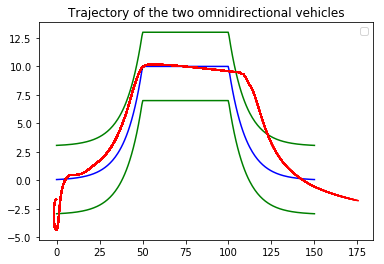

(44418, 44418) (44418, 1) (1160, 44418) (1160, 1) (2328, 44418) (2328, 1)
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  2.2868e+00 -2.9075e+03  3e+04  7e-01  2e-10
 1:  2.4048e+00 -1.3293e+03  8e+03  2e-01  2e-10
 2:  1.3179e+01 -9.4909e+02  5e+03  1e-01  8e-10
 3:  2.8352e+01 -6.7030e+02  4e+03  6e-02  9e-10
 4:  6.0571e+01 -2.0510e+02  1e+03  2e-02  9e-10
 5:  7.5835e+01  5.6768e+00  1e+02  1e-03  4e-10
 6:  7.5477e+01  6.5513e+01  2e+01  2e-04  1e-10
 7:  7.4688e+01  7.2191e+01  5e+00  4e-05  9e-11
 8:  7.4429e+01  7.3777e+01  1e+00  7e-06  5e-11
 9:  7.4380e+01  7.4143e+01  4e-01  2e-06  3e-11
10:  7.4362e+01  7.4294e+01  1e-01  5e-07  1e-11
11:  7.4357e+01  7.4343e+01  2e-02  7e-08  6e-12
12:  7.4356e+01  7.4351e+01  8e-03  2e-08  3e-12


KeyboardInterrupt: 

In [14]:
x00 = [[x_path[0][0] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][1] + 3.0 * (2 * random.random() - 1.0), \
              x_path[0][2] + 1.0 * (2 * random.random() - 1.0), \
              x_path[0][3] + 3.0 * (2 * random.random() - 1.0)]]  # Initial state.

for epoch in range(epoch_init, num_epoch + epoch_init):  # loop over the dataset multiple times
    dataloader = data_utils.DataLoader(agent.dataset, batch_size = agent.batch_size, shuffle = True)
    running_loss = 0.0
    
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.float().to(agent.device), labels.float().to(agent.device)
        inputs.requires_grad = True
        
        agent.optimizer.zero_grad()
        
        outputs = agent.model(inputs)
        outputs = torch.reshape(outputs, (outputs.size()[0], agent.output_size))
        
        loss = agent.criterion(outputs, labels)
        loss.backward()
    
        # print statistics

  
        running_loss += loss.item()
        agent.optimizer.step()
        #agent.run()
           
            
    if epoch % 5 == 0:
        print('[Epoch %d] avg_loss: %.3f' % (epoch + 1, running_loss/len(dataloader)))
        torch.save({'epoch': epoch, \
                    'model_state_dict': agent.model.state_dict(), \
                    'optimizer_state_dict': agent.optimizer.state_dict(), \
                    'loss': loss}, str('checkpoints/' + str(agent.model_name) + '_' + str(epoch) + '.pt'))
        x0 = x00

        N = 300
        n = 10
        agent_traj = []
        
        f_x = np.empty((N -n + 1, dynamics.state_size, dynamics.state_size))
        f_u = np.empty((N -n + 1, dynamics.state_size, dynamics.action_size))
        g_x = np.empty((N -n + 1, dynamics.action_size, dynamics.state_size, ))
        g_theta = np.empty((N -n + 1, dynamics.action_size, agent.num_parameters(agent.model)))
        '''
        print(f_x.shape)
        print(f_u.shape)
        print(g_x.shape)
        print(g_theta.shape)
        '''
        
        F_x = np.empty((N - n + 1, dynamics.state_size, dynamics.state_size))
        F_theta = np.empty((N - n + 1, dynamics.state_size, agent.num_parameters(agent.model)))
        
        # Search every time step
        for i in range(int(N - n) + 1):
            # Generate (state, control) pairs
            x = []
            for j in x0[0]:
                x.append(j)
            for j in range(len(x_path[i: i + n])):
                for k in range(len(x_path[j + i])):
                    x.append(x_path[j + i][k])
            x = np.asarray([x])
            x = torch.tensor(x, requires_grad = True).float().to(agent.device)
            
            agent.optimizer.zero_grad()
            u = agent.model(x)
            
            
            for j in range(dynamics.action_size):
                # Get gradient w.r.t input x[0:4] <<<< g_x
                g_x[i, j, :] = torch.autograd.grad(u[0, j], x, retain_graph = True\
                                                  )[0].cpu().numpy()[0, 0:dynamics.state_size]
                
                # Get gradient w.r.t model parameters theta <<<< g_theta
                torch.autograd.backward(u[0, j], retain_graph = True)
                k = 0
                for theta in agent.model.parameters():
                    g_theta_ = theta.grad.data.flatten() 
                    g_theta[i, j, k : k + g_theta_.size()[0]] = g_theta_.cpu().numpy()
                    k += g_theta_.size()[0]
            
            
            x = x.detach().cpu().numpy()
            u = u.detach().cpu().numpy()
            
            # Get dynamics w.r.t x <<<< f_x         
            f_x[i] = dynamics.f_x(x[0, 0:4], u[0], i)
            
            # Get dynamics w.r.t u <<<< f_u
            f_u[i] = dynamics.f_u(x[0, 0:4], u[0], i)
            
            # Record the trajectory
            agent_traj[-1].append([x[0], u[0]])
                              
            # Find next state
            x0 = dynamics.f(x[0, 0:4], u[0], i)
            
            # Calculate f_x + f_u g_x
            F_x[i] = f_x[i] + f_u[i].dot(g_x[i])
            # Calculate f_u g_theta
            F_theta[i] = f_u[i].dot(g_theta[i])
        
        draw_agent_traj(x_path, [agent_traj])
        
        # Define QP objective Q, p
        Q = np.eye(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))
        q = np.zeros((dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model), 1))
        
        # Define QP constraint Ax = b, Gx <= h
        A = np.zeros((dynamics.state_size * (N - n), \
                      dynamics.state_size * (N - n + 1) \
                      + agent.num_parameters(agent.model)))
        
        b = np.zeros((dynamics.state_size * (N - n), 1))
        G = np.zeros((2 * dynamics.state_size * (N - n + 1), \
                      dynamics.state_size * (N - n + 1)\
                      + agent.num_parameters(agent.model)))
        h = np.zeros((2 * dynamics.state_size * (N - n + 1), 1))
        
        for i in range(0, N - n + 1):
            x = agent_traj[i][0]
            u = agent_traj[i][1]
            
            if i <= N - n - 1:
                A[dynamics.state_size * i : dynamics.state_size * (i + 1), \
                  dynamics.state_size * i : dynamics.state_size * (i + 1)] = F_x[i, :]
                A[dynamics.state_size * i : dynamics.state_size * (i + 1), \
                  dynamics.state_size * (i + 1) : dynamics.state_size * (i + 2)] = - np.eye(dynamics.state_size)
                A[dynamics.state_size * i : dynamics.state_size * (i + 1),\
                  -agent.num_parameters(agent.model) : ] = F_theta[i, :]
                
            G[dynamics.state_size * 2 * i + 1, dynamics.state_size * i + 1] = 1.0
            G[dynamics.state_size * (2 * i + 1) + 1, dynamics.state_size * i + 1] =  - 1.0
            
            if i != 0:
                h[dynamics.state_size * 2 * i + 1] = nominal(x[0])[0] - x[1]
                h[dynamics.state_size * (2 * i + 1) + 1] = x[1] - nominal(x[0])[1]
        
            for j in range(dynamics.state_size):
                Q[i * dynamics.state_size + j] = 0.0
        
        
        print(Q.shape, q.shape, A.shape, b.shape, G.shape, h.shape)
        
        Q = numpy_sparse_to_spmatrix(Q)
        q = matrix(q)
        A = numpy_sparse_to_spmatrix(A)
        b = matrix(b)
        G = numpy_sparse_to_spmatrix(G)
        h = matrix(h)
        print("Starting solving QP")
        sol=solvers.qp(Q, q, G, h, A, b)
        #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
        delta_theta = list(sol['x'])

        pickle.dump(delta_theta, open('model_parameter_perturbation_' + str(i) + '.p', 'wb'))
        print('QP solved')
        print('Model prameter updated')
        
        i = dynamics.state_size * (N - n + 1)
        for theta in agent.model.parameters():
            theta.data += torch.FloatTensor(delta_theta[i: i + theta.data.numel()]).reshape(theta.data.size()).to(agent.device)
            i += theta.data.numel()
        
